In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
car = pd.read_csv("trans2_confBasedRules.csv",index_col=0)
#car = pd.read_csv("/content/gdrive/My Drive/FCA/Data Files/WithoutNF/withoutNFrules_CAR.csv")

# car = pd.read_csv("/content/gdrive/My Drive/DataFiles/k-fold/rules/strat_trans3Final.csv")

print(len(car))

39463


In [0]:
car.head()

,premise,consequence,support,confidence
125,"{Difference Entropy, Edema}",{Infiltration},0.01,0.43
134,"{Difference Entropy, Pneumonia}",{Infiltration},0.00,0.41
173,"{Edema, Sum Entropy}",{Infiltration},0.01,0.42
183,"{Pneumonia, Sum Entropy}",{Infiltration},0.00,0.41
214,"{Cardiomegaly, Dissimilarity}",{Effusion},0.00,0.42


In [0]:
print(car.loc[car.index[7], 'premise'])

{Correlation, Homogeneity}


## Separating each class's rules

In [0]:
import warnings
warnings.filterwarnings('ignore')

Labels = {'Pneumothorax', 'Effusion', 'Atelectasis', 'Mass', 'No Finding',
       'Pleural_Thickening', 'Nodule', 'Fibrosis', 'Edema', 'Infiltration',
       'Cardiomegaly', 'Hernia', 'Pneumonia', 'Emphysema', 'Consolidation'}

# without NoFinding
# Labels = {'Pneumothorax', 'Effusion', 'Atelectasis', 'Mass',
#        'Pleural_Thickening', 'Nodule', 'Fibrosis', 'Edema', 'Infiltration',
#        'Cardiomegaly', 'Hernia', 'Pneumonia', 'Emphysema', 'Consolidation'}

def separate_rules(label):
    disease = pd.DataFrame()
    disease = car[car.consequence.str.contains(label,case=False)]
    return disease


def sorter(df):
    len_lhs=[]
  
    for i in df.index:
        p = df.at[i, 'premise']
        if isinstance(p, str):
            p = p.replace('{', '')
            p = p.replace('}', '')
            p = set(p.split(', '))
            df['premise'][i] = p
      
        c = set(df.at[i, "consequence"])
        if isinstance(c, str):
            c = c.replace('{', '')
            c = c.replace('}', '')
            c = set(c.split(', '))
            df['consequence'][i] = c
      
        len_lhs.append(len(list(p)))

    df['LengthLHS'] = len_lhs
    df.sort_values(by=['confidence', 'LengthLHS'], ascending=False, inplace=True)
    return df

Pneumothorax = sorter(separate_rules('Pneumothorax'))
Effusion = sorter(separate_rules('Effusion'))
Atelectasis = sorter(separate_rules('Atelectasis'))
Mass = sorter(separate_rules('Mass'))
NoFinding = sorter(separate_rules('No Finding'))
Pleural_Thickening = sorter(separate_rules('Pleural_Thickening'))
Nodule = sorter(separate_rules('Nodule'))
Fibrosis = sorter(separate_rules('Fibrosis'))
Edema = sorter(separate_rules('Edema'))
Infiltration = sorter(separate_rules('Infiltration'))
Cardiomegaly = sorter(separate_rules('Cardiomegaly'))
Hernia = sorter(separate_rules('Hernia'))
Pneumonia = sorter(separate_rules('Pneumonia'))
Emphysema = sorter(separate_rules('Emphysema'))
Consolidation = sorter(separate_rules('Consolidation'))

In [0]:
print(Effusion.shape)
print(Hernia.shape)
print(NoFinding.shape)

(11726, 5)
(12, 5)
(4, 5)


#### Begin Jaccard Similarity match

In [0]:
#Compute and return jaccard similarity index between premise and instance

def jaccard_sim(premise, instance):
    j = len(premise.intersection(instance))/len(premise.union(instance))
    return j

In [0]:
def check_df(df, feature_set, labels):
    r = df.shape[0]
    if(r>51):
        rules_to_match = 51
    else:
        rules_to_match = r
    jaccardvalues = {}
    ctr = 0
    
    for i in df.index:
        if(ctr == rules_to_match):
            break
        premise = df.at[i, 'premise']
        feat_prem = set()

        for el in premise:
            if not(el in labels):
                feat_prem.add(el)

        if not(feat_prem == set()) and feat_prem.issubset(feature_set):
            ctr += 1
            jac = jaccard_sim(feat_prem, feature_set)
            jaccardvalues.update({i:jac})
    return jaccardvalues

In [0]:
import numpy as np

def test_jaccard(X, Y, feat_list, labels):  
    
    predictions = []
    count = 0
    
    for a in range(len(X)):
        pred = [0]*len(labels)
        feature_set = set()
        for j in range(16):
          #16: n_features
            if X[a][j] == 1:
                feature_set.add(str(feat_list[j]))

        all_values = {}

        j1 = check_df(Pneumothorax, feature_set, labels)
        #getting index of rule having max jaccard coeff
        if bool(j1):
            pneum = max(j1, key=j1.get)
            all_values.update({pneum:j1[pneum]})
      
        j2 = check_df(Effusion, feature_set, labels)
        if bool(j2):
            eff = max(j2, key=j2.get)
            all_values.update({eff:j2[eff]})
        
        j3 = check_df(Atelectasis, feature_set, labels)
        if bool(j3):
            atel = max(j3, key=j3.get)
            all_values.update({atel:j3[atel]})
       
        j4 = check_df(Mass, feature_set, labels)
        if bool(j4):
            mas = max(j4, key=j4.get)
            all_values.update({mas:j4[mas]})
        
        j5 = check_df(NoFinding, feature_set, labels)
        if bool(j5):
            nof = max(j5, key=j5.get)
            all_values.update({nof:j5[nof]})
        
        j6 = check_df(Pleural_Thickening, feature_set, labels)
        if bool(j6):
            pleu = max(j6, key=j6.get)
            all_values.update({pleu:j6[pleu]})
        
        j7 = check_df(Nodule, feature_set, labels)
        if bool(j7):
            nodu = max(j7, key=j7.get)
            all_values.update({nodu:j7[nodu]})
        
        j8 = check_df(Fibrosis, feature_set, labels)
        if bool(j8):
            fibr = max(j8, key=j8.get)
            all_values.update({fibr:j8[fibr]})
        
        j9 = check_df(Edema, feature_set, labels)
        if bool(j9):
            edem = max(j9, key=j9.get)
            all_values.update({edem:j9[edem]})
        
        j10 = check_df(Infiltration, feature_set, labels)
        if bool(j10):
            infil = max(j10, key=j10.get)
            all_values.update({infil:j10[infil]})
        
        j11 = check_df(Cardiomegaly, feature_set, labels)
        if bool(j11):
            card = max(j11, key=j11.get)
            all_values.update({card:j11[card]})
        
        j12 = check_df(Hernia, feature_set, labels)
        if bool(j12):
            hern = max(j12, key=j12.get)
            all_values.update({hern:j12[hern]})
        
        j13 = check_df(Pneumonia, feature_set, labels)
        if bool(j13):
            pneumon = max(j13, key=j13.get)
            all_values.update({pneumon:j13[pneumon]})

        j14 = check_df(Emphysema, feature_set, labels)
        if bool(j14):
            emph = max(j14, key=j14.get)
            all_values.update({emph:j14[emph]})

        j15 = check_df(Consolidation, feature_set, labels)
        if bool(j15):
            cons = max(j15, key=j15.get)
            all_values.update({cons:j15[cons]})

      #print(all_values)
        if bool(all_values):
            rule_ind = max(all_values, key=all_values.get)
            #print(rule_ind)
            con = car.at[rule_ind, 'consequence']
            #print(con)
            if isinstance(con, str):
                con = con.replace('{','')
                con = con.replace('}','')
                con = set(con.split(', '))
            for c in con:
                pred[labels.index(c)] = 1
      
        else:
        #print("No match for instance ", a+1)
            pred[labels.index('No Finding')] = 1
      
        predictions.append(pred)
        if pred == list(Y[a]):
            count += 1

    #print('Correctly classified = ', count)
    return predictions

In [0]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, precision_recall_fscore_support

def evaluation(Y, predictions, labels):
        
    predictions = np.array(predictions)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    precision = dict()
    recall = dict()
    
    for i in range(15):
        fpr[labels[i]], tpr[labels[i]], _ = roc_curve(Y[:,i], predictions[:,i])
        roc_auc[labels[i]] = auc(fpr[labels[i]], tpr[labels[i]])
        precision[labels[i]], recall[labels[i]], _ = precision_recall_curve(Y[:, i], predictions[:, i])
 
    plt.figure()
    for i in range(15):
        string = labels[i] + ' ROC curve area = ' + str(roc_auc[labels[i]])
        plt.plot(fpr[labels[i]], tpr[labels[i]], label=string)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(bbox_to_anchor = (1.1, 1.05))
    plt.savefig('roc_data2', bbox_inches = 'tight')
    #plt.show()

    plt.figure()
    for i in range(15):
        plt.plot(recall[labels[i]], precision[labels[i]], label=labels[i])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Precision-Recall curve')
        plt.legend(bbox_to_anchor = (1.1, 1.05))
    plt.savefig('prec_recall_data2', bbox_inches = 'tight')
    #plt.show()
    
    predictions = predictions.flatten()
    Y = Y.flatten()
    auc_t = roc_auc_score(Y,predictions,average="weighted")
    print("Combined auc (weighted): " ,auc_t)
    auc_m = roc_auc_score(Y,predictions,average="macro")
    print("Combined auc (macro): " ,auc_m)
    
    prs_mic = precision_recall_fscore_support(Y, predictions, average='micro', zero_division=0)
    prs_mac = precision_recall_fscore_support(Y, predictions, average='macro', zero_division=0)
    prs_wtd = precision_recall_fscore_support(Y, predictions, average='weighted', zero_division=0)
    print("Micro averaged precision = ", prs_mic[0])
    print("Macro averaged precision = ", prs_mac[0])
    print("Weighted averaged precision = ", prs_wtd[0])
    
    print("Micro averaged recall = ", prs_mic[1])
    print("Macro averaged recall = ", prs_mac[1])
    print("Weighted averaged recall = ", prs_wtd[1])
    
    print("Micro averaged fscore = ", prs_mic[2])
    print("Macro averaged fscore = ", prs_mac[2])
    print("Weighted averaged fscore = ", prs_wtd[2])

In [0]:
# data_frame = pd.read_csv("/content/gdrive/My Drive/FCA/Data Files/FinalData1/test.csv", index_col=0)
data_frame = pd.read_csv("test2.csv")
data_frame.drop(['index'], axis=1, inplace = True)
# data = pd.read_csv("/content/gdrive/My Drive/DataFiles/k-fold/test/strat_testFold3.csv", index_col=0)
data = data_frame.sample(5)

In [0]:
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np

kdis = KBinsDiscretizer(n_bins = 2, encode = "ordinal", strategy = "kmeans")

for c in data.columns[2:18]:
    c_dash = []
    temp = np.reshape(np.array(data[c]), (-1,1))
    c_dash = kdis.fit_transform(temp)
    data[c] = c_dash

In [0]:

X = data.values[:, 2:18].astype(int)
Y = data.values[:, 18:33].astype(int)

Combined auc (weighted):  0.4420289855072464
Combined auc (macro):  0.4420289855072464
Micro averaged precision =  0.8133333333333334
Macro averaged precision =  0.4552238805970149
Weighted averaged precision =  0.8376119402985074
Micro averaged recall =  0.8133333333333334
Macro averaged recall =  0.4420289855072464
Weighted averaged recall =  0.8133333333333334
Micro averaged fscore =  0.8133333333333334
Macro averaged fscore =  0.4485294117647059
Weighted averaged fscore =  0.8252941176470588


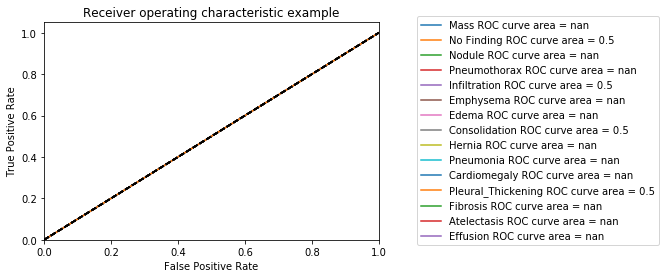

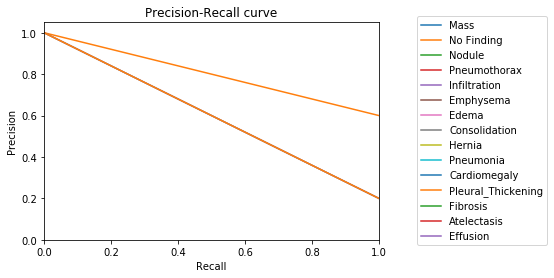

In [0]:
feature_names = data.columns[2:18]
label_names = data.columns[18:33]
features = []

#removing space from between the feature names, because thats how they are in rules
for item in feature_names:
    it = item.replace(" ","")
    features.append(it)

pred = test_jaccard(X, Y, list(features), list(label_names))
evaluation(Y, pred, list(label_names))

In [0]:
print(Y.shape)
print(Y[:, 3])

(5, 15)
[0 0 0 1 0]


## Previous Approach

In [0]:
#for i in range(len(car)):
  #if car.support[i] == 0:
   #car.drop(i,inplace=True)

#print(len(car))
#car.reset_index(drop=True, inplace=True)

470


In [0]:
classes = set()
for ind in car.index:
  c = car.at[ind,'consequence']
  if isinstance(c, str):
    c = c.replace('}','')
    c = c.replace('{','')
  c = set(c.split(', '))
  classes = classes.union(c)
print(classes)

{'Pneumothorax', 'Atelectasis', 'Fibrosis', 'Infiltration', 'Mass', 'Consolidation', 'No Finding', 'Effusion', 'Hernia', 'Nodule', 'Emphysema', 'Pleural_Thickening', 'Edema', 'Cardiomegaly', 'Pneumonia'}


In [0]:
#'''
len_lhs=[]

for i in car.index:
    p = car.at[i, 'premise']
    if isinstance(p, str):
      p = p.replace('{', '')
      p = p.replace('}', '')
      p = p.replace(' ', '')
      premise = set(p.split(','))
      car['premise'][i] = premise
      #print(premise)
    
    c = car.at[i, "consequence"]
    if isinstance(c, str):
      c = c.replace('{', '')
      c = c.replace('}', '')
      c = c.replace(' ', '')
      cons = set(c.split(','))
      car['consequence'][i] = cons
    
    len_lhs.append(len(list(premise)))

car['LengthLHS'] = len_lhs
#'''

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
car = car.sort_values(by=["confidence","LengthLHS"], ascending=False)
#car = car.sort_values(by=["confidence", "LengthLHS"], ascending=[False, True])
#car = car.sort_values(by=["New Confidence","confidence", "LengthLHS"], ascending=False)

#run this if the rules arent sorted

In [0]:
car.head()
#car.to_csv("CAR.csv", index=False)
#run this to save sorted rules to csv

,premise,consequence,support,confidence,LengthLHS
10849,"{Contrast, Atelectasis, Homogeneity, SumEntrop...",{Infiltration},0.0,0.85,6
10850,"{Contrast, Atelectasis, SumEntropy, InverseDif...",{Infiltration},0.0,0.85,6
10851,"{Atelectasis, Homogeneity, SumEntropy, Cluster...",{Infiltration},0.0,0.85,6
10852,"{Atelectasis, SumEntropy, InverseDifferenceMom...",{Infiltration},0.0,0.85,6
10853,"{Variance, Atelectasis, Homogeneity, SumEntrop...",{Infiltration},0.0,0.85,6


In [0]:
#car = pd.read_csv("CAR.csv")
def car_lookup(feature_set, labels):
    
    prediction = [0]*len(labels)
    flag = False
    
    for i in car.index:
        
        premise = car.at[i, 'premise']
        '''
        premise = premise.replace("{","")
        premise = premise.replace("}","")
        premise = premise.replace(" ","")
        premise = set(premise.split(","))
        '''
        feat_prem = set()
        
        for el in premise:
            if not(el in labels):
                feat_prem.add(el)
        
        #print("F = ", feat_prem)
        #print("Premise = ", feat_prem)
        #print("Feature = ", feature_set)
        
        if not(feat_prem == set()) and feat_prem.issubset(feature_set):  #or if premise == feature_set
            #print("Premise = ", feat_prem)
            #print("Feature = ", feature_set)
            flag = True
            cons = car.at[i, "consequence"]
            '''           
            cons = cons.replace("{","")
            cons = cons.replace("}","")
            cons = cons.replace(" ","")
            cons = set(cons.split(","))
            '''
            #print("* CONS = ", cons)
            for item in cons:
                if item == 'NoFinding':
                  item = 'No Finding'
                  # flag = False
                  # break
                try:
                    prediction[labels.index(item)] = 1
                    #print(prediction)
                except ValueError:
                    pass    

        if flag:
          return prediction
    
    if not flag:
      # prediction = [0]*len(labels)
      # prediction[labels.index('No Finding')] = 1
      return prediction

In [0]:
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

def classif_train(X, Y, feat_list, lab_list):
    predictions = []
    ctr = 0
    for i in range(len(X)):
        feature_set = set()
        for j in range(16):
            #16: n_features
            if X[i][j] == 1:
                feature_set.add(str(feat_list[j]))
        
        #scan rules
        p = car_lookup(feature_set, lab_list)
        predictions.append(p)
        
        
        if (p == list(Y[i])):
          ctr += 1
        
        # if i%1000 == 0:
        #   print("T - ", Y[i])
        #   print("P - ", p)

    print("Correctly classified = ", ctr) 
    acc = accuracy_score(Y, predictions)
    print("Accuracy = ", acc*100)

    predictions = np.array(predictions)
    try:
      auc = roc_auc_score(Y, predictions, average=None)
    except ValueError:
      pass
    tempdf = pd.DataFrame()
    tempdf['label'] = lab_list
    tempdf['AUC'] = auc
    print("Class-wise auc : \n", tempdf)


    predictions = predictions.flatten()
    Y = Y.flatten()
    auc = roc_auc_score(Y,predictions,average="weighted")
    print("Combined auc : " ,auc)

In [0]:
# data = pd.read_csv("/content/gdrive/My Drive/DataFiles/Basic_30k.csv", index_col=0)
data = pd.read_csv("/content/gdrive/My Drive/DataFiles/k-fold/test/strat_testFold3.csv", index_col=0)

In [0]:
data.shape

(10028, 33)

In [0]:
from sklearn.preprocessing import KBinsDiscretizer

kdis = KBinsDiscretizer(n_bins = 2, encode = "ordinal", strategy = "kmeans")

for c in data.columns[2:18]:
    c_dash = []
    temp = np.reshape(np.array(data[c]), (-1,1))
    c_dash = kdis.fit_transform(temp)
    data[c] = c_dash

In [0]:

X = data.values[:, 2:18].astype(int)
Y = data.values[:, 18:33].astype(int)

In [0]:
feature_names = data.columns[2:18]
label_names = data.columns[18:33]
features = []

#removing space from between the feature names, because thats how they are in rules
for item in feature_names:
    it = item.replace(" ","")
    features.append(it)

classif_train(X, Y, list(features), list(label_names))

Correctly classified =  635
Accuracy =  6.332269644994017
Class-wise auc : 
                  label       AUC
0         Pneumothorax  0.500000
1             Effusion  0.495791
2          Atelectasis  0.501489
3                 Mass  0.500000
4           No Finding  0.500158
5   Pleural_Thickening  0.500000
6               Nodule  0.500000
7             Fibrosis  0.500000
8                Edema  0.500000
9         Infiltration  0.535619
10        Cardiomegaly  0.500000
11              Hernia  0.500000
12           Pneumonia  0.500000
13           Emphysema  0.500000
14       Consolidation  0.500000
Combined auc :  0.5250910219774165


In [0]:
print(type(Hernia.at[Hernia.index[5], 'premise']))

<class 'numpy.ndarray'>
